In [1]:
import sys
sys.path.append('..')

from VarPro import *

# Gaussian convolution in 2d
The model is a convolution with a gaussian kernel in 2d

In [5]:
## Teacher model
scale = 0.5
activation = ActivationFunction(lambda t: torch.exp(-t/scale) / scale**2) ## activation function

w_lim = 2
clipping_function = PeriodicBoundaryCondition(x_min=-w_lim, x_max=w_lim)
clipper = FeatureClipper(clipping_function)

teacher_width = 4096

modes = w_lim * torch.tensor([[-0.5, 0], [0.5, 0.5], [0.2, -0.5]], dtype=torch.float32)

gamma = 100

teacher_weight = torch.tensor(generate_periodic_distribution(teacher_width, dim=2, gamma=gamma), dtype=torch.float32)
#teacher_weight = gamma * torch.randn((teacher_width, 2), dtype=torch.float32)

teacher_weight[::3] += modes[0]
teacher_weight[1::3] += modes[1]
teacher_weight[2::3] += modes[2]


teacher = Convolution(2, teacher_width, activation, clipper=clipper)

teacher.feature_model.weight = nn.Parameter(data=teacher_weight) ## teacher feature distribution
teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight, dtype=torch.float32)) ## teacher outer weight

teacher.clipper(teacher)
teacher.apply(freeze)

/Users/rbarboni/Documents/GitHub/VarPro/VarPro_convolution_2d/../Utilities.py:97: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


VarProModel(
  (feature_model): ConvolutionFeatureModel(
    (activation): ActivationFunction()
  )
  (outer): Linear(in_features=4096, out_features=1, bias=False)
)

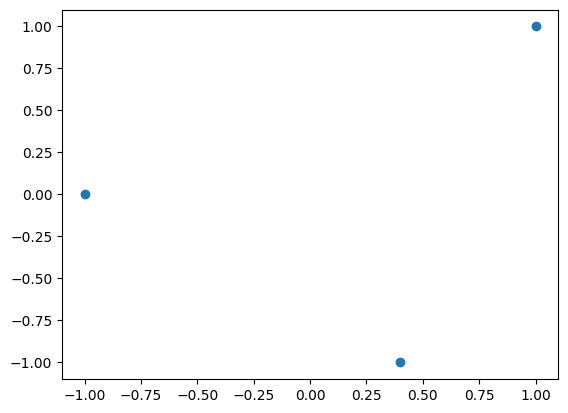

In [46]:
# plot of the teacher feature distribution
w = teacher.feature_model.weight
plt.scatter(modes[:,0], modes[:,1])

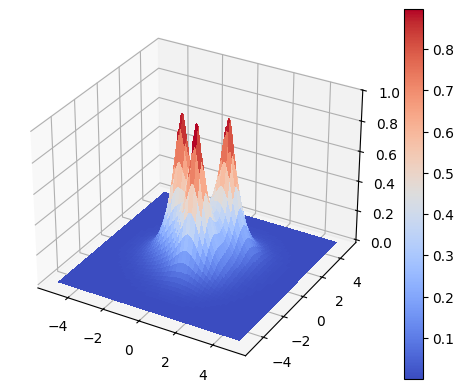

In [6]:
# plot of the teacher signal
_ = model_plot_2d(teacher)

In [48]:
# creating the dataset
N = 4096

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [49]:
## Student model
student_width = 512
#clipper = FeatureClipper(Normalization())

# uniform initialization
init = w_lim * (2 * torch.rand((student_width, 2), dtype=torch.float32) - 1)

student = Convolution(2, student_width, activation, clipper=clipper, VarProTraining=True)

student.feature_model.weight = nn.Parameter(data=init.clone().detach(), requires_grad=True)
student.clipper(student)

In [50]:
inputs, targets = next(iter(train_loader))
features = student.feature_model(inputs).clone().detach()

K = features.T @ features / (N * student_width)

In [51]:
torch.linalg.norm(K, ord=2) # should be close to 1

tensor(0.1413)

In [52]:
## Training
lmbda = 1e-3
time_scale = 2**(-10)
lr = student_width * time_scale

# biased or unbiased loss
criterion = VarProCriterionUnbiased(lmbda)

## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
criterion.projection(inputs, targets, student)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight], lr=lr)
#optimizer.add_param_group({'lr': 5*student_width*lmbda, 'params': student.outer.weight})

In [53]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [54]:
epochs = 10000
problem.train(epochs)

log10(loss) = -1.38: 100%|██████████| 10000/10000 [05:15<00:00, 31.69it/s]


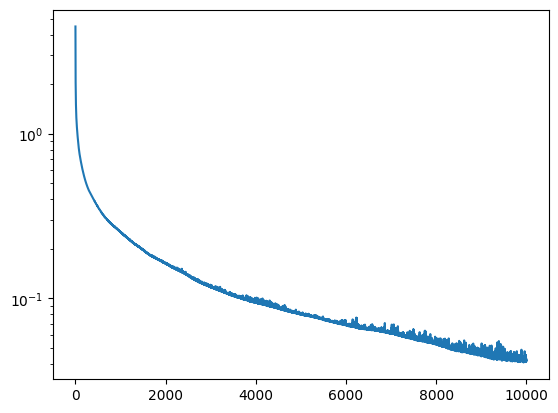

In [55]:
# training loss
plt.plot(problem.loss_list)
plt.yscale('log')
#plt.xscale('log')

#### Distance to the teacher distribution

In [56]:
distance_teacher_list = []
distance_teacher_idx = [int(i) for i in np.linspace(0, len(problem.state_list)-1, 1001)]
for i in tqdm(distance_teacher_idx):
    w1 = problem.state_list[i]['feature_model.weight']
    w2 = teacher.feature_model.weight
    distance_teacher_list.append(compute_distance(DistanceMMD(projection=clipping_function), w1, w2).item())


100%|██████████| 1001/1001 [00:42<00:00, 23.31it/s]


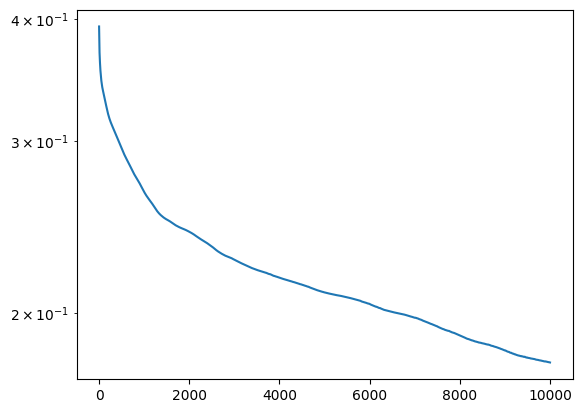

In [57]:
plt.plot(distance_teacher_idx, distance_teacher_list)
plt.yscale('log')
#plt.xscale('log')

# Exact solution in 1D
Numerical resolution of the weighted ultra-fast diffusion in 1d

In [25]:
import gzip
import pickle

path = 'diffusion_gamma100_ts-10.pkl.gz'
with gzip.open(path, 'rb') as file:
    f_list = pickle.load(file)

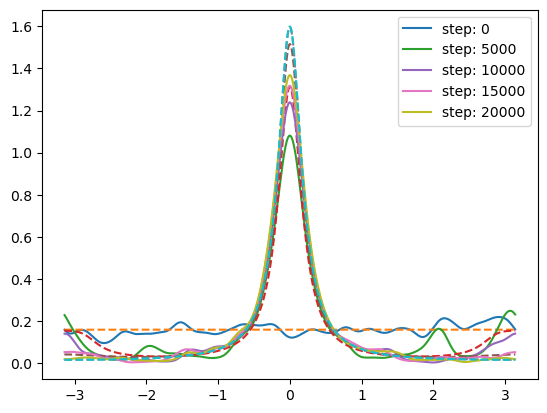

In [33]:
M = f_list.shape[1]
X = np.linspace(-np.pi, np.pi, M+1)
X = 0.5 * (X[1:]+X[:-1])

for i in np.arange(0, 20001, 5000):
    w = problem.state_list[i]['feature_model.weight'].numpy()
    f = circle_to_line(w)
    
    plt.plot(*gaussian_conv(f, scale=0.1), label=f'step: {i}')
    plt.plot(X, f_list[i], '--')
plt.legend()
#plt.yscale('log')

In [34]:
w2 = torch.tensor([[np.cos(x), np.sin(x)] for x in X], dtype=torch.float32)

distance_diffusion_list = []
distance_diffusion_idx = [int(i) for i in np.linspace(0, epochs, 1000)]
for i in tqdm(distance_diffusion_idx):
    w1 = problem.state_list[i]['feature_model.weight']
    c2 = torch.tensor(f_list[i],dtype=torch.float32) * 2*np.pi / M
    distance_diffusion_list.append(compute_distance(DistanceMMD(), w1, w2, c2=c2).item())


100%|██████████| 1000/1000 [00:27<00:00, 36.54it/s]


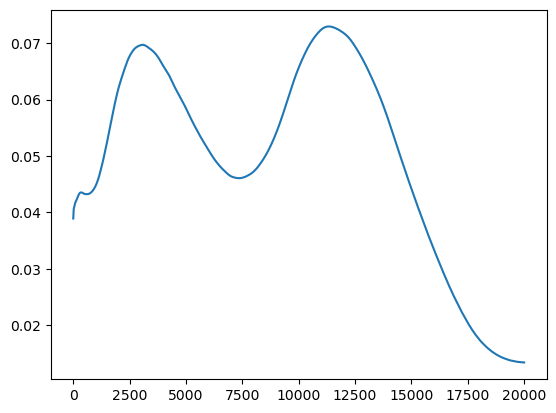

In [35]:
plt.plot(distance_diffusion_idx, distance_diffusion_list)
#plt.yscale('log')

## Compute exact solution

In [14]:
from scipy.integrate import odeint

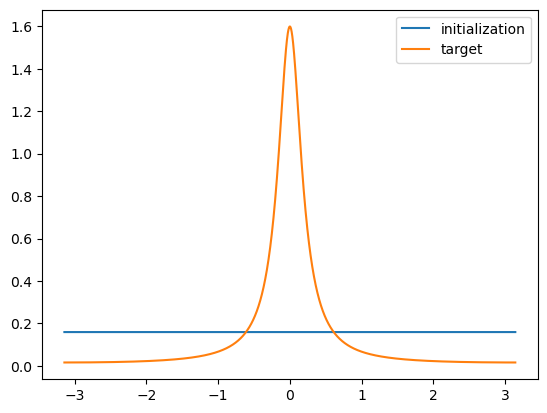

In [15]:
M = 4096

X = np.linspace(-np.pi, np.pi, M+1)
X = 0.5 * (X[1:]+X[:-1])

f0 = normalize(np.ones(M)) ## initialization
f_star = normalize(1 / (1 + gamma * np.sin(X/2)**2)) ## target

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(X, f0, label='initialization')
ax.plot(X, f_star, label='target')
plt.legend()
#ax.axis('equal')

In [16]:
def F(f, t):
    return - 0.5 * f * Laplacian((f_star / f)**2, h=2*np.pi/M) - 0.5 * Grad((f_star / f)**2, h=2*np.pi/M) * Grad(f, h=2*np.pi/M)

In [17]:
T = 25000
t = np.linspace(0, T*time_scale, T+1)
f_list = odeint(F, f0, t)

In [24]:
import gzip
import pickle

path = 'diffusion_gamma100_ts-10.pkl.gz'
with gzip.open(path, 'wb') as file:
    pickle.dump(f_list, file)